<h1> ResNet18 Pre-trained-Model with PyTorch </h1>


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<ul>
    <li><a href="https://#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="https://#data_class"> Dataset Class</a></li>
</ul>
 </div>
<hr>


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [1]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob

torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [3]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="concrete_data_1"
        positive="Positive"
        negative='Negative'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        image=Image.open(self.all_files[idx])
        y = self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)])

train_dataset = Dataset(transform=composed,train=True)
validation_dataset = Dataset(transform=composed,train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of data element:  torch.Size([3, 227, 227])
Type of data element:  torch.LongTensor


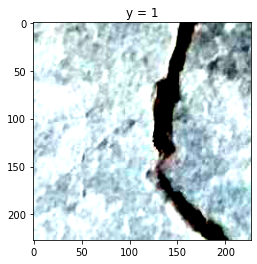

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


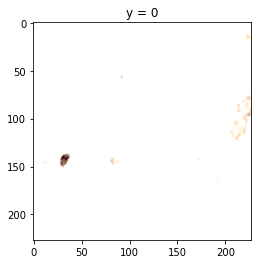

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


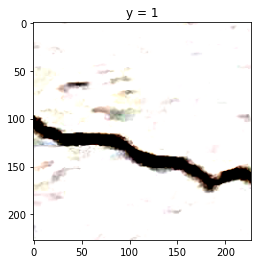

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


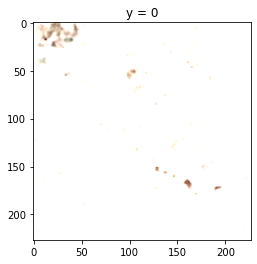

In [5]:
def show_data(data_sample, shape = (227, 227, 3)):
    # (3 x 227 x 227) => (227 x 227 x 3)
    transposed_imarr = np.transpose(data_sample[0].numpy().reshape((3, 227, 227)), (1, 2, 0))
    # BGR format => RGB format
    assert transposed_imarr.shape == shape
    B, G, R = transposed_imarr.T
    rgb_imarr = np.array((R, G, B)).T
    plt.imshow(rgb_imarr)
    plt.title('y = {}'.format(data_sample[1]))
    plt.show()

print("Shape of data element: ", train_dataset[0][0].shape)
print("Type of data element: ", train_dataset[0][1].type())
for i in range(4):
    show_data(train_dataset[i])

<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [6]:
model = models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [7]:
for param in model.parameters():
    param.requires_grad = False



<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [8]:
model.fc = nn.Linear(512,2)


In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Train the Model</h2>


<b>Step 1</b>: Create a cross entropy criterion function


In [10]:
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)
print(len(train_loader))


300


<b>Step 3</b>: Use the following optimizer to minimize the loss


In [12]:
optimizer = torch.optim.SGD([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.01)

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [13]:
n_epochs = 5

def train(model, train_loader, validate_loader, optimizer, criterion, dataset_val, epochs):
    results = {'train_loss': [], 'validation_acc': []}
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))
        # train
        COST = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            COST += loss.data
        results['train_loss'].append(COST)
        print('train_loss: {}'.format(COST))

        # evaluate
        correct = 0
        for x,y in validate_loader:
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
        accuracy = 100 * (correct / len(dataset_val))
        results['validation_acc'].append(accuracy)
        print('val_accuracy: {}'.format(accuracy))
    return results
training_results = train(model, train_loader, validation_loader, optimizer, criterion, validation_dataset, n_epochs)

Epoch: 0
train_loss: 37.43596267700195
val_accuracy: 99.2
Epoch: 1
train_loss: 14.45986270904541
val_accuracy: 99.31
Epoch: 2
train_loss: 11.104747772216797
val_accuracy: 99.39
Epoch: 3
train_loss: 9.46734619140625
val_accuracy: 99.42999999999999
Epoch: 4
train_loss: 8.4517240524292
val_accuracy: 99.44


[tensor(37.4360), tensor(14.4599), tensor(11.1047), tensor(9.4673), tensor(8.4517)]


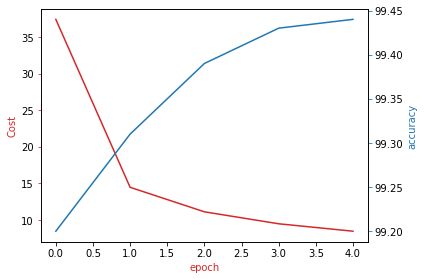

In [14]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(training_results['train_loss'], color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(training_results['validation_acc'], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
print(training_results['train_loss'])

<h2 >Find the misclassified samples</h2>


<b>Identify the first four misclassified samples using the validation data:</b>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


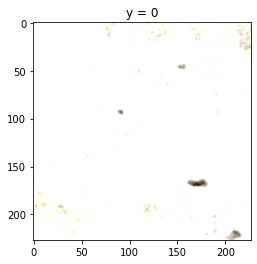

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample 1 predicted value: tensor([1]) actual value:0


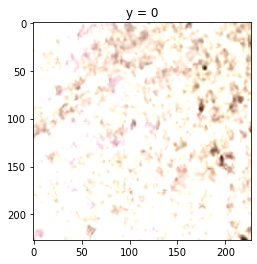

sample 3 predicted value: tensor([1]) actual value:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


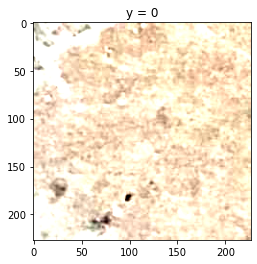

sample 5 predicted value: tensor([1]) actual value:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


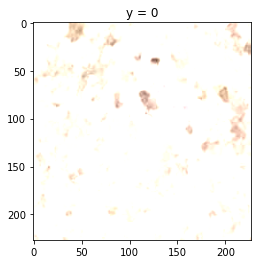

sample 7 predicted value: tensor([1]) actual value:0


In [15]:
count = 0
i = 0
for x_test, y_test in validation_dataset:
    outputs = model(x_test.view(-1, 3, 227, 227))
    _, yhat = torch.max(outputs, 1)
    if yhat != y_test:
        show_data((x_test, y_test))
        plt.show()
        print('sample {0} predicted value: {1} actual value:{2}'.format(i, yhat, y_test))
        count += 1
    i += 1
    if count >= 4:
        break